In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import itertools 
from collections import defaultdict


## Table of Content
* [Cleaning & Preparation](#Cleaning-&-Preparation)
    * [Read Table](#Read-Table)
    * [Transform](#Transform)

<br>

* [Markov Chain](#Markov-Chain-Modelling)
    * [Transition Matrix](#Transition-Matrix)
    * [Removal Effect](#Removal-Effect)

<br>

* [Another Application](#Another-Application)
    * [Product Acquisition](#Product-Acquisition)

<br>

* [Appendix](#Appendix-&-Notes)

`Markov Chain` is named after the Russian mathematician Andrey Markov; it describes a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.

In the context of marketing channel attribution, `Markov Chain` gives us a framework to model user journeys and how each channel factors into the users traveling from one channel to another to eventually purchase (or not). 

In this notebook, we will use the Google Analytics (GA) traffic data to identify the probabilities of moving from one marketing channel event to another, and thereafter conversions (or not), in a 3-month window.

<img src="markov chain.png" width="400"/>

## Cleaning & Preparation

### Read Table
[Back to top](#Table-of-Content)

In [4]:
df_raw = pd.read_csv('Channel Attribution example data.csv')

In [5]:
df_raw.head(6)

,clientID,visitDate,channel,conversion,revenue
0,10006173,2/4/21,organic,1,197.70
1,10001777,7/4/21,organic,1,237.70
2,10001616,24/4/21,organic,1,720.65
3,10006205,10/5/21,organic,1,1932.45
4,10006186,17/4/21,organic,1,867.70
5,10006164,3/4/21,organic,1,717.70


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6774363 entries, 0 to 6774362
Data columns (total 5 columns):
clientID      object
visitDate     object
channel       object
conversion    int64
revenue       float64
dtypes: float64(1), int64(1), object(3)
memory usage: 258.4+ MB


This is a raw table containing all site visits from March to May 2021. `conversion` indicate whether the particular entry include a product purchase. 

**This dataset will include incomplete and repeated journeys**:
    * First engagement started before March, no transaction within the chosen period
    * First engagement started before March, first transaction occurred within the chosen period
    * First engagement started and transacted before March, re-engaged within the chosen period
    * Multiple transactions occurred during the chosen period
    * First engaged started during the chosen period, may or may not transact by end of period
    
**Based on this, this exercise assumes**:
    1. All journeys are considered to be starting in March and completed by end of May - 90 days window
    2. First time transaction/journey is viewed as equal to repreated transaction/journey.
    
**Other general assumptions are**:
    1. All campaigns or activities within the same channel are considered to be homogeneous. 
    2. Immediate subsequent visits from the same channel are ignored - unique channel interactions only.   

### Transform
[Back to top](#Table-of-Content)

The raw data contains all visit entries and possibly all conversions within the chosen period for each scg_id. To effectively measure the channel attribution, we would need to first isolate all the activities prior to each conversion as separate journeys.

In [6]:
#assign visit number and journey number
df_raw['visitNum'] = df_raw.groupby('clientID').cumcount() + 1
df_raw['journeyNum'] = df_raw.groupby('clientID')['conversion'].transform(lambda x: x.diff().ne(1).cumsum())

In [8]:
df_raw.tail(10)

,clientID,visitDate,channel,conversion,revenue,visitNum,journeyNum
16182,10016122,1/3/21,direct,0,0.0,2,2
16183,10026145,1/3/21,direct,0,0.0,3,3
16184,10026047,1/3/21,organic,0,0.0,10,10
16185,10026144,1/3/21,organic,0,0.0,1,1
16186,10026145,1/3/21,organic,0,0.0,4,4
16187,10026145,1/3/21,newsletter,0,0.0,5,5
16188,10021458,1/3/21,direct,0,0.0,1,1
16189,10026134,1/3/21,direct,0,0.0,12,12
16190,10026066,1/3/21,organic,0,0.0,2,2
16191,10025628,1/3/21,referral,0,0.0,43,43


In [12]:
df_raw[df_raw['clientID'].isin(['10026134'])]

,clientID,visitDate,channel,conversion,revenue,visitNum,journeyNum
12012,10026134,3/3/21,direct,0,0.0,1,1
12099,10026134,5/3/21,direct,0,0.0,2,2
12237,10026134,8/3/21,direct,0,0.0,3,3
12282,10026134,9/3/21,direct,0,0.0,4,4
12329,10026134,10/3/21,direct,0,0.0,5,5
12387,10026134,11/3/21,direct,0,0.0,6,6
12432,10026134,12/3/21,direct,0,0.0,7,7
12621,10026134,16/3/21,direct,0,0.0,8,8
12673,10026134,17/3/21,direct,0,0.0,9,9
12736,10026134,18/3/21,direct,0,0.0,10,10


In [13]:
#aggregate unique channel touch point per journey
df_paths= df_raw.groupby(['clientID','journeyNum'])['channel'].aggregate(lambda x: x.unique().tolist()).reset_index()

#find out last interaction per journey
df_last_interaction = df_raw.drop_duplicates(['clientID','journeyNum'],
                                               keep='last')[['clientID','journeyNum','conversion']]

#append conversion result
df_paths= pd.merge(df_paths, df_last_interaction, how='left', on=['clientID','journeyNum'])

#adding beginning and end to the path
df_paths['path'] = np.where(df_paths['conversion'] == 0,
                              df_paths['channel'].apply(lambda x: ['start']+ x + ['null']),
                              df_paths['channel'].apply(lambda x: ['start']+ x + ['conversion']))

In [14]:
df_paths.head(5)

,clientID,journeyNum,channel,conversion,path
0,004849fb,1,[direct],0,"[start, direct, null]"
1,00a05537,1,[direct],0,"[start, direct, null]"
2,00ccf3fb,1,[direct],0,"[start, direct, null]"
3,01d71064,1,[direct],0,"[start, direct, null]"
4,0234d2d0,1,[direct],0,"[start, direct, null]"


In [124]:
df_paths.to_csv('df_paths.csv', header=True, index=False)

## Markov Chain Modelling

### Transition Matrix
[Back to top](#Table-of-Content)

In [15]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('conversion') for path in df_paths['path'].tolist()) #conversion count
total_conversions_value=df_raw.revenue.sum() #conversion revenue
base_conversion_rate = total_conversions / len(list_of_paths)
print('Base conversion over this period is {:.2%}'.format(base_conversion_rate))

Base conversion over this period is 73.81%


Base conversion rate is very high, because this is fake data.

In [16]:
#function to identity all possible transition
def transition_states(list_of_paths):
    #create a set of unique channels
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
   
    #initial a dict for all transition permutations with a count of 0
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
    
    for possible_state in list_of_unique_channels:
        if possible_state not in ['conversion', 'null']: #remove ending state
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s] 
                    for col in indices:
                        #retrieve the particular transition pair in the dict, adds 1 to the count
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1 
                        
    return transition_states

trans_states = transition_states(list_of_paths)

In [17]:
dict(itertools.islice(trans_states.items(), 8)) 

{'googlePaidSearch>googlePaidSearch': 0,
 'googlePaidSearch>organic': 0,
 'googlePaidSearch>W+App': 0,
 'googlePaidSearch>newsletter': 0,
 'googlePaidSearch>conversion': 1320,
 'googlePaidSearch>qrScan': 0,
 'googlePaidSearch>start': 0,
 'googlePaidSearch>social': 0}

In [18]:
#function to calculate transition probability
def transition_prob(list_of_paths,trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict) #if key is not found, create a new entry
    
    for state in list_of_unique_channels:
        if state not in ['conversion', 'null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s] 
                                                                    #find starting state's row index                
                   
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0: #where there is a transition
                    counter += trans_dict[list(trans_dict)[col]] #total occurance of all transitions                  
                    
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter) 
                                                                    #transition of a particular state
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(list_of_paths,trans_states)

In [19]:
dict(itertools.islice(trans_prob.items(), 8))

{'googlePaidSearch>conversion': 0.9315455187014821,
 'googlePaidSearch>null': 0.068454481298518,
 'organic>conversion': 0.8184443409408477,
 'organic>null': 0.1815556590591523,
 'W+App>conversion': 0.980072463768116,
 'W+App>null': 0.019927536231884056,
 'newsletter>conversion': 0.026595744680851064,
 'newsletter>null': 0.973404255319149}

In [20]:
#function to produce the transition matrix
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    
    #set up the frame for the cross-matrix
    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00 #set column channel to 0
        trans_matrix.loc[channel] = 0.00 #set row channel to 0 with channel as index
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['conversion', 'null'] else 0.0
    
    #populate value
    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix

trans_matrix = transition_matrix(list_of_paths, trans_prob)

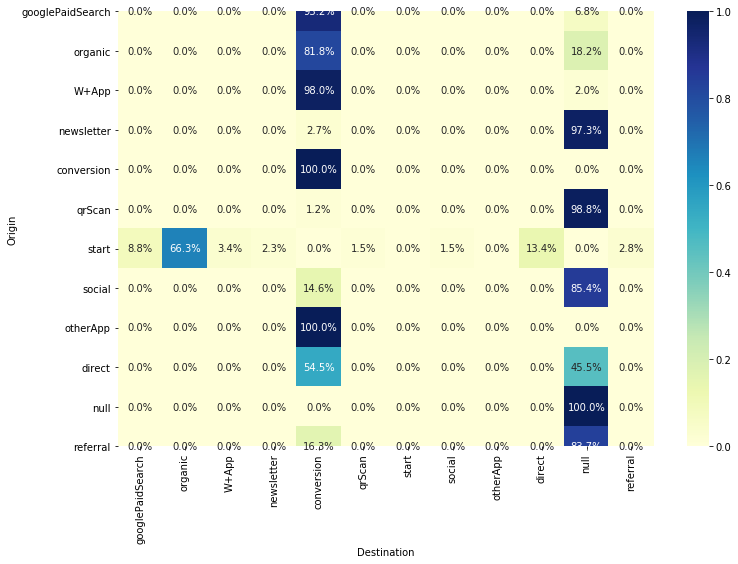

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(trans_matrix, cmap="YlGnBu", annot=True, fmt='.1%')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

### Removal Effect
[Back to top](#Table-of-Content)

To measure the importance of each channel/campaign by calculating, we would calculate `Removal Effect` for each channel. A channel’s effectiveness is determined by removing it completely from the `Markov Chain` graph and simulating the new buyer journeys, measuring the change in success rate without it in place. `Removal Effect` is a proxy for weight, in terms of marketing attribution.

To calculate each channel’s attribution value we can use the following formula: **A = V * (Rt / Rv)**
   * **A** = Channel’s attribution value
   * **V** = Total value to divide. In our case, it is the total GDC revenue in the 3 months period
   * **Rt** = Channel’s Removal Effect
   * **Rv** = Sum of all Removal Effect values

In [22]:
#function to calculate removal effect
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['start', 'null', 'conversion']]
    
    for channel in channels:
        #dropping the channel in transition matrix
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0) 
        
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column])) #row sum without the channel
            null_pct = float(1) - row_sum #effect of the channel in row
           
            if null_pct != 0:
                removal_df.loc[column]['null'] = null_pct 
            removal_df.loc['null']['null'] = 1.0
        
        #matrix only containing the last transient states, and final destination/absorbing state - R
        removal_to_conv = removal_df[['null', 'conversion']].drop(['null', 'conversion'], axis=0)
        
        #matrix only containing the transient states - Q
        removal_to_non_conv = removal_df.drop(['null', 'conversion'], axis=1).drop(['null', 'conversion'], axis=0)

        # compute the fundamental matrix N
        removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) #generate identity matrix
                                            - np.asarray(removal_to_non_conv)
                                        )
        #calculate dot product for matrix B (B=N*R)
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        
        #calculate new conversion rate
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict

removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [23]:
removal_effects_dict

{'googlePaidSearch': 0.11045100828382537,
 'organic': 0.7351686051376454,
 'W+App': 0.04526817839511321,
 'newsletter': 0.0008367500627560753,
 'qrScan': 0.0002510250188267893,
 'social': 0.0029286252196467633,
 'otherApp': 8.367500627548541e-05,
 'direct': 0.09873650740523787,
 'referral': 0.006275625470671842}

In [24]:
#function to calculate final allocation
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}

attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [25]:
attributions

{'googlePaidSearch': 1319.9999999999986,
 'organic': 8786.000000000011,
 'W+App': 540.9999999999986,
 'newsletter': 9.999999999997868,
 'qrScan': 2.9999999999989626,
 'social': 34.99999999999851,
 'otherApp': 0.9999999999983274,
 'direct': 1179.9999999999993,
 'referral': 74.99999999999928}

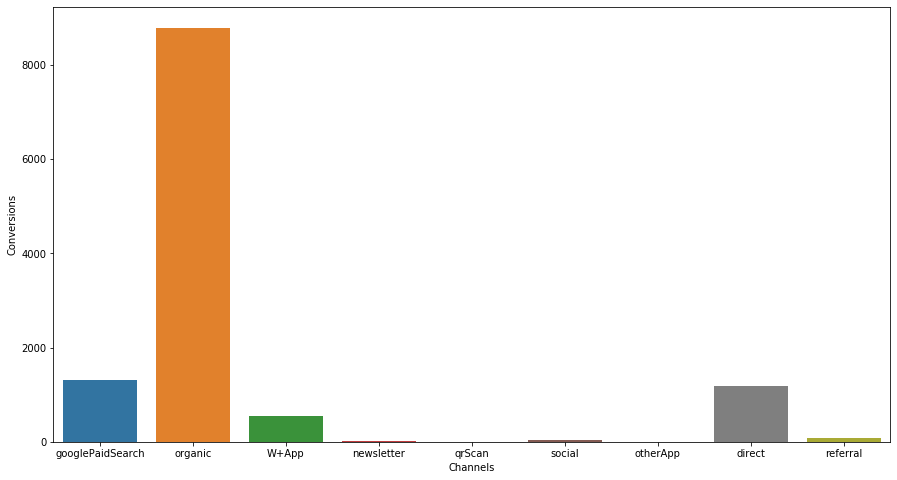

In [26]:
df_attributions = pd.DataFrame(attributions.items())
plt.figure(figsize=(15,8))
sns.barplot(x=0, y=1, data=df_attributions);
plt.xlabel('Channels');
plt.ylabel('Conversions');

In [27]:
attributions_value = markov_chain_allocations(removal_effects_dict, total_conversions_value)
attributions_value

{'googlePaidSearch': 1393806.0200820004,
 'organic': 9277257.34275794,
 'W+App': 571249.2855033039,
 'newsletter': 10559.13651577049,
 'qrScan': 3167.740954730727,
 'social': 36956.977805203016,
 'otherApp': 1055.913651575508,
 'direct': 1245978.1088611826,
 'referral': 79193.5238682948}

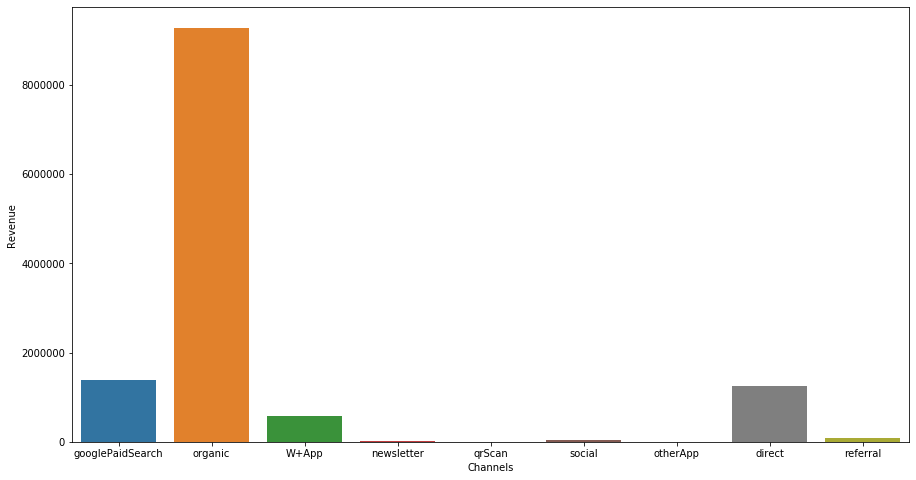

In [28]:
df_attributions_value = pd.DataFrame(attributions_value.items())
plt.figure(figsize=(15,8))
sns.barplot(x=0, y=1, data=df_attributions_value);
plt.xlabel('Channels');
plt.ylabel('Revenue');

## Another Application

### Product Acquisition
[Back to top](#Table-of-Content)

The `Markov Chain` model framework can also be applied to users product acquisition journeys. By looking into the transition probability and the users' current state, we can identify cross sell opportunities (the next product to recommend to the users.

In [29]:
df_prod = pd.read_csv('Product journey example data.csv')

In [30]:
df_prod.head()

,customer_id,acquisition_source_name,acquisition_timestamp
0,ba31ffaf,product_B,2020-01-12 19:50:54 UTC
1,84715cef,product_B,2019-10-23 04:07:44 UTC
2,ebb78b3f,product_B,2019-12-01 03:59:56 UTC
3,27848d3a,product_B,2019-09-17 17:13:26 UTC
4,0fd428d9,product_B,2020-02-17 02:11:49 UTC


In [35]:
df_paths_prod= df_prod.sort_values(['customer_id',
                'acquisition_timestamp']).groupby('customer_id')['acquisition_source_name'].aggregate(
                                                            lambda x: x.unique().tolist()).reset_index()

df_paths_prod['path'] = df_paths_prod['acquisition_source_name'].apply(lambda x: ['start']+ x + ['null'])

In [36]:
df_prod[df_prod['customer_id']=='ba31ffaf']

,customer_id,acquisition_source_name,acquisition_timestamp
0,ba31ffaf,product_B,2020-01-12 19:50:54 UTC
6122,ba31ffaf,product_C,2018-09-11 11:26:37 UTC
13492,ba31ffaf,product_A,2020-01-12 19:50:55 UTC


In [37]:
df_paths_prod[df_paths_prod['customer_id']=='ba31ffaf']

,customer_id,acquisition_source_name,path
5506,ba31ffaf,"[product_C, product_B, product_A]","[start, product_C, product_B, product_A, null]"


In [39]:
list_of_paths_prod = df_paths_prod['path']
trans_states_prod = transition_states(list_of_paths_prod)
trans_prob_prod = transition_prob(list_of_paths_prod,trans_states_prod)
trans_matrix_prod = transition_matrix(list_of_paths_prod, trans_prob_prod)

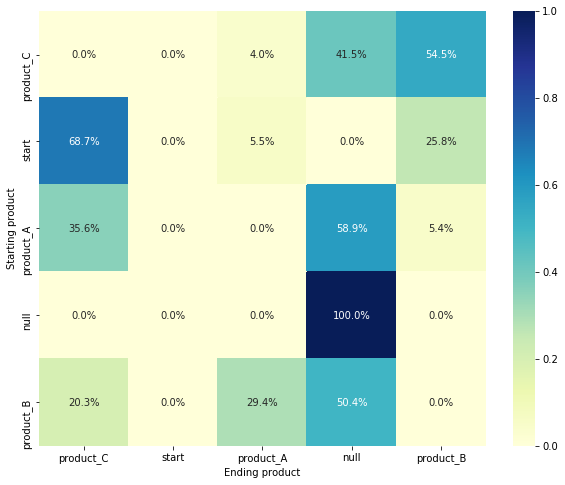

In [40]:
plt.figure(figsize=(10,8))
ax=sns.heatmap(trans_matrix_prod, cmap="YlGnBu", annot=True, fmt='.1%')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Ending product')
plt.ylabel('Starting product')
plt.show()

Looking at the transition matrix, it seems 69% of our total customers started their journey with `product_C`, while 26% started with the `product_B`. Other insights we can draw are:
   * **product_C** customers tend to flow into `product_B`
   * **product_A** customers tend to flow into `product_C` 
   * **product_B** customers only sometimes flow into `product_A` and `product_C`

## Appendix 
[Back to top](#Table-of-Content)

### Matrix Algebra

Refer to https://en.wikipedia.org/wiki/Absorbing_Markov_chain for the maths foundation of the above matrix calculation.

Basically, since we have an ending/absorbing state of either 'conversion' or 'null', we have an `Absorbing Markov Chain`, which comes with its own properties. One of these properties is we can calculate the expected number of visits to a transient state **j** starting from a transient state **i** via the `Fundamental Matrix`.

The probability of transitioning from a transient state **i** to another transient state **j** (before being absorbed) in exactly **k** steps is the (i,j)-entry of **Q<sup>k</sup>**. where **Q** describes the probability of transitioning from some transient state to another. Summing this for all **k** (from 0 to ∞) yields the `Fundamental Matrix`, denoted by N. It can be proven that:

<img src="fundamental matrix.png" width="200"/>

Another property is that we can also calculate the probability of being absorbed in the absorbing state **j** when starting from transient state **i**, which is the (i,j)-entry of the matrix **B**. We have formula **B = N * R** , where **R** describes the probability of transitioning from some transient state to some absorbing state.